In [1]:
import numpy as np
import torch

from functools import partial

from kusanagi.shell import cartpole
from kusanagi.base import ExperienceDataset, apply_controller
from kusanagi.ghost.control import RandPolicy

from prob_mbrl import utils, models, algorithms, losses, train_regressor
torch.set_num_threads(2)

In [2]:
def forward(states, actions, dynamics, **kwargs):
    deltas, rewards = dynamics(
        (states, actions), return_samples=True,
        separate_outputs=True, **kwargs)
    next_states = states + deltas
    return next_states, rewards


def reward_fn(states, target, Q, angle_dims):
    states = utils.to_complex(states, angle_dims)
    reward = losses.quadratic_saturating_loss(states, target, Q)
    return reward

In [3]:
# parameters
H = 25
N_particles = 50
dyn_components = 2
dyn_hidden = [200]*2
pol_hidden = [200]*2

# initialize environment
env = cartpole.Cartpole()

# initialize reward/cost function
target = torch.tensor([0, 0, 0, np.pi]).float()
D = target.shape[-1]
U = 1
learn_reward = False
maxU = np.array([10.0])
angle_dims = torch.tensor([3]).long()
target = utils.to_complex(target, angle_dims)
Da = target.shape[-1]
Q = torch.zeros(Da, Da).float()
Q[0, 0] = 1
Q[0, -2] = env.l
Q[-2, 0] = env.l
Q[-2, -2] = env.l**2
Q[-1, -1] = env.l**2
Q /= 0.1
if learn_reward:
    reward_func = None
else:
    reward_func = partial(
        reward_fn, target=target, Q=Q, angle_dims=angle_dims)


# initialize dynamics model
dynE = 2*(D+1) if learn_reward else 2*D
dyn_model = models.dropout_mlp(
            Da+U, (dynE+1)*dyn_components, dyn_hidden,
            dropout_layers=[models.modules.CDropout(0.1, 0.1)
                            for i in range(len(dyn_hidden))],
            nonlin=torch.nn.ReLU,
            weights_initializer=torch.nn.init.xavier_normal_,
            biases_initializer=partial(torch.nn.init.uniform_, a=-1.0, b=1.0),
        )
dyn = models.DynamicsModel(
    dyn_model, reward_func=reward_func,
    angle_dims=angle_dims,
    output_density=models.MixtureDensity(dynE/2, dyn_components)).float()

# initalize policy
pol_model = models.dropout_mlp(
        Da, U, pol_hidden,
        dropout_layers=[models.modules.BDropout(0.1)
                        for i in range(len(pol_hidden))],
        nonlin=torch.nn.ReLU,
        output_nonlin=torch.nn.Tanh)

pol = models.Policy(pol_model, maxU, angle_dims=angle_dims).float()
randpol = RandPolicy(maxU)

# initalize experience dataset
exp = ExperienceDataset()

# initialize policy optimizer
params = filter(lambda p: p.requires_grad, pol.parameters())
opt = torch.optim.Adam(params, 1e-4, amsgrad=True)

# define functions required for rollouts
forward_fn = partial(forward, dynamics=dyn)

[2018-07-12 11:04:21.271604] Experience > Initialising new experience dataset


In [4]:
# collect initial random experience
for rand_it in range(1):
    ret = apply_controller(
        env, randpol, H,
        callback=None)
    exp.append_episode(*ret)

[2018-07-12 11:04:21.285105] apply_controller > Starting run
[2018-07-12 11:04:21.286605] apply_controller > Running for 2.500000 seconds
[2018-07-12 11:04:21.418333] apply_controller > Done. Stopping robot. Value of run [24.890926]
[2018-07-12 11:04:21.419682] Cartpole > Stopping robot


[2018-07-12 11:04:30.632725] apply_controller > Starting run
[2018-07-12 11:04:30.634192] apply_controller > Running for 2.500000 seconds
[2018-07-12 11:04:30.778959] apply_controller > Done. Stopping robot. Value of run [24.763420]
[2018-07-12 11:04:30.780608] Cartpole > Stopping robot


log-likelihood of data: 3.803127: 100%|█████████▉| 997/1000 [00:07<00:00, 126.43it/s] 


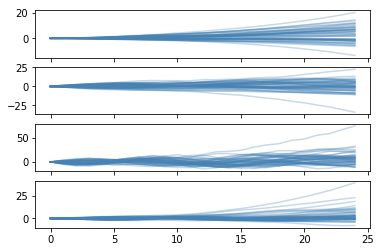

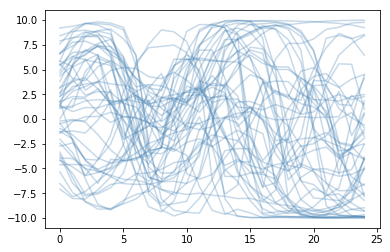

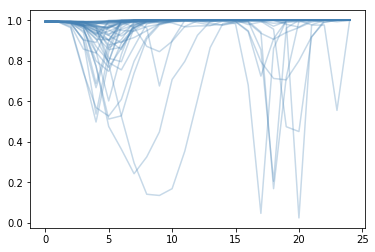

/home/juancamilog/miniconda2/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Accumulated costs: 0.990095:   0%|          | 2/1000 [00:00<01:31, 10.91it/s]

Policy search iteration 1


Accumulated costs: 0.739876: 100%|██████████| 1000/1000 [01:24<00:00, 11.77it/s]


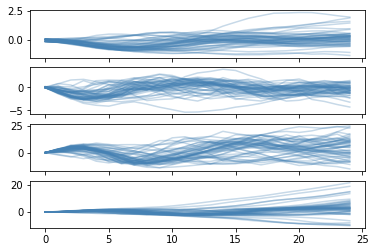

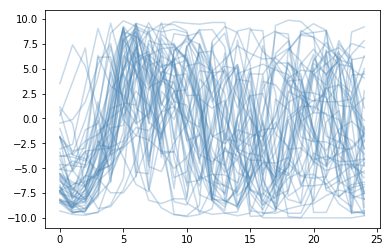

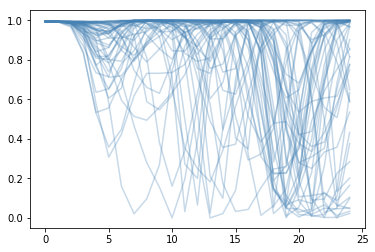

[2018-07-12 11:06:07.219622] apply_controller > Starting run
[2018-07-12 11:06:07.221224] apply_controller > Running for 2.500000 seconds
[2018-07-12 11:06:07.373556] apply_controller > Done. Stopping robot. Value of run [22.733120]
[2018-07-12 11:06:07.374790] Cartpole > Stopping robot


log-likelihood of data: 3.959674: 100%|█████████▉| 997/1000 [00:07<00:00, 127.32it/s]


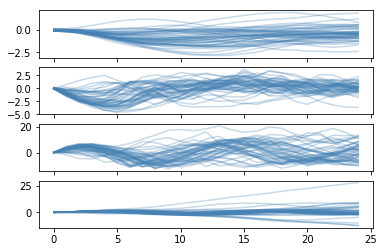

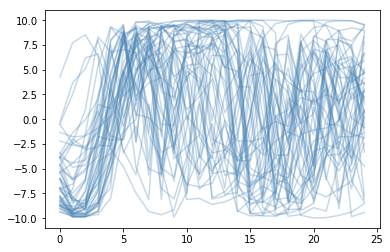

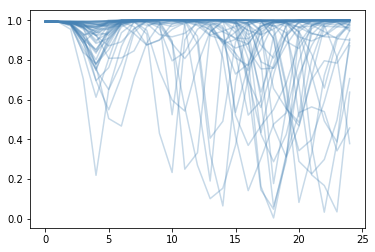

Accumulated costs: 0.876885:   0%|          | 2/1000 [00:00<01:23, 11.97it/s]

Policy search iteration 2


Accumulated costs: 0.826319: 100%|██████████| 1000/1000 [01:51<00:00,  8.97it/s]


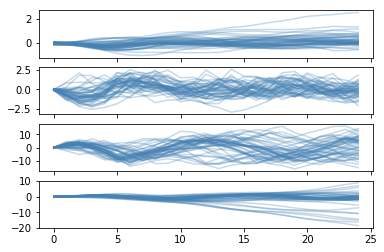

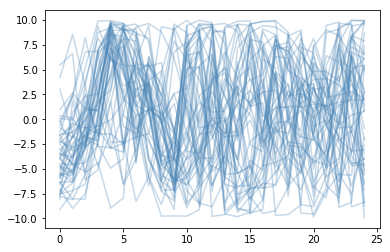

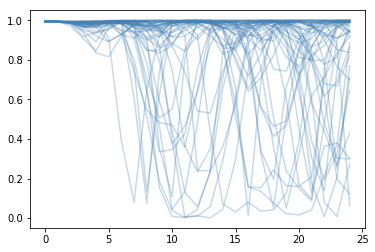

[2018-07-12 11:08:10.411861] apply_controller > Starting run
[2018-07-12 11:08:10.413446] apply_controller > Running for 2.500000 seconds
[2018-07-12 11:08:10.563332] apply_controller > Done. Stopping robot. Value of run [22.112419]
[2018-07-12 11:08:10.564704] Cartpole > Stopping robot


log-likelihood of data: 4.859136: 100%|█████████▉| 999/1000 [00:08<00:00, 120.64it/s]


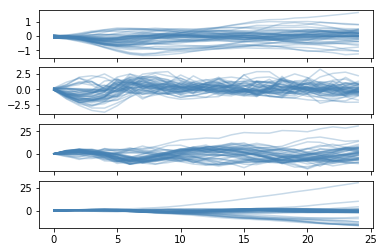

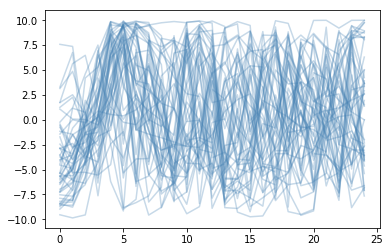

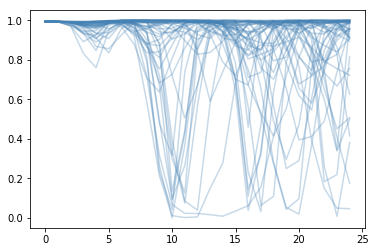

Accumulated costs: 0.834049:   0%|          | 2/1000 [00:00<01:31, 10.93it/s]

Policy search iteration 3


Accumulated costs: 0.785368: 100%|██████████| 1000/1000 [01:26<00:00, 11.55it/s]


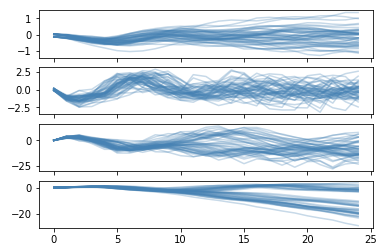

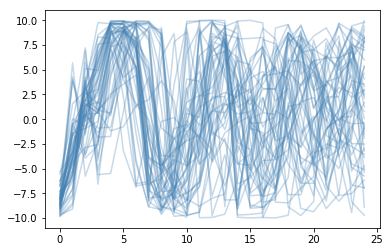

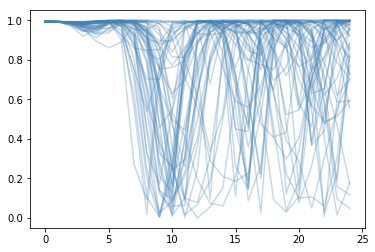

[2018-07-12 11:09:49.135031] apply_controller > Starting run
[2018-07-12 11:09:49.136847] apply_controller > Running for 2.500000 seconds
[2018-07-12 11:09:49.296682] apply_controller > Done. Stopping robot. Value of run [18.893433]
[2018-07-12 11:09:49.297895] Cartpole > Stopping robot


log-likelihood of data: 5.180882: 100%|█████████▉| 998/1000 [00:08<00:00, 123.14it/s]


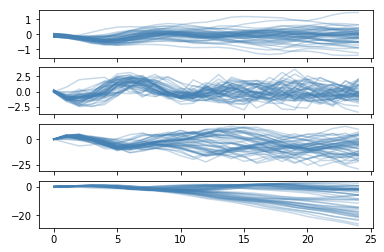

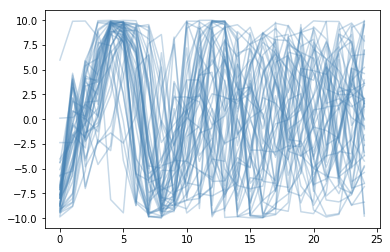

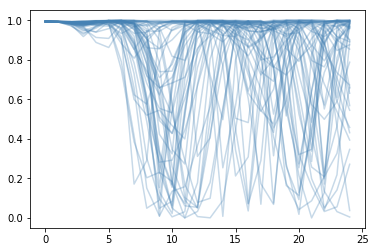

Accumulated costs: 0.815636:   0%|          | 2/1000 [00:00<01:27, 11.37it/s]

Policy search iteration 4


Accumulated costs: 0.752095: 100%|██████████| 1000/1000 [01:26<00:00, 11.53it/s]


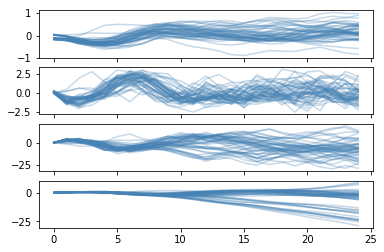

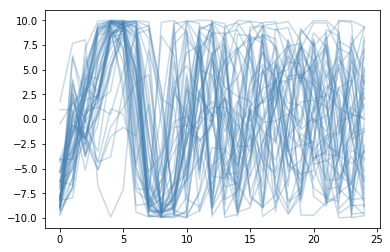

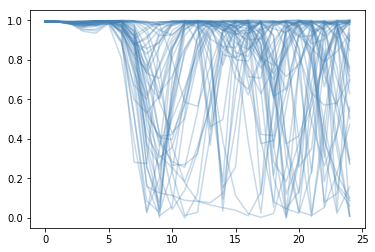

[2018-07-12 11:11:27.911570] apply_controller > Starting run
[2018-07-12 11:11:27.914042] apply_controller > Running for 2.500000 seconds
[2018-07-12 11:11:28.081687] apply_controller > Done. Stopping robot. Value of run [22.755325]
[2018-07-12 11:11:28.082970] Cartpole > Stopping robot


log-likelihood of data: 5.186668: 100%|█████████▉| 997/1000 [00:08<00:00, 121.56it/s]


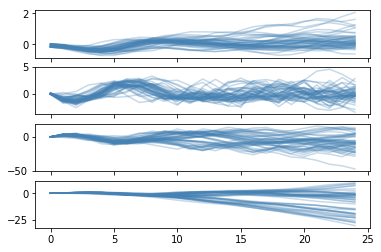

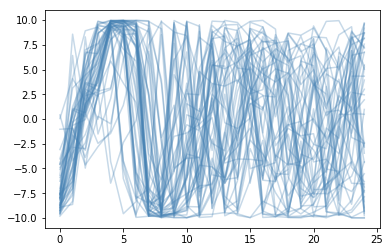

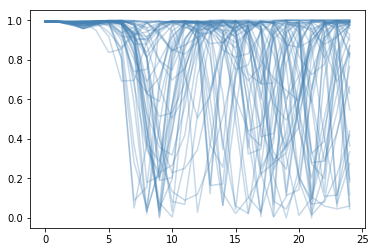

Accumulated costs: 0.820735:   0%|          | 2/1000 [00:00<01:26, 11.53it/s]

Policy search iteration 5


Accumulated costs: 0.736203: 100%|██████████| 1000/1000 [01:26<00:00, 11.61it/s]


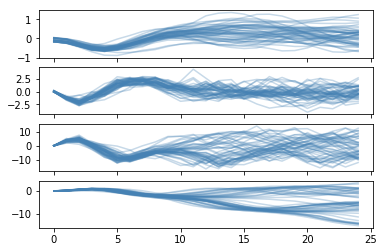

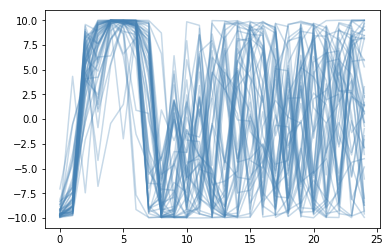

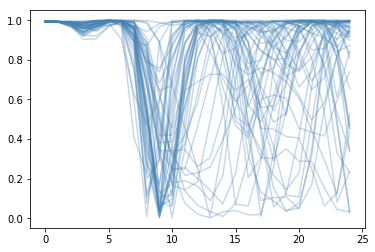

[2018-07-12 11:13:06.157113] apply_controller > Starting run
[2018-07-12 11:13:06.158672] apply_controller > Running for 2.500000 seconds
[2018-07-12 11:13:06.309153] apply_controller > Done. Stopping robot. Value of run [20.949482]
[2018-07-12 11:13:06.310434] Cartpole > Stopping robot


log-likelihood of data: 5.636592: 100%|██████████| 1000/1000 [00:08<00:00, 118.27it/s]


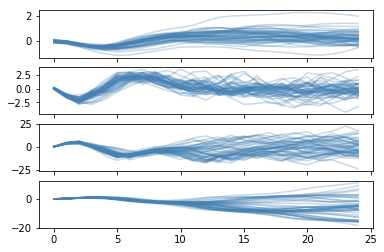

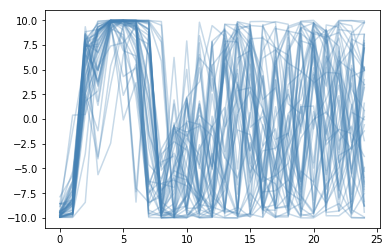

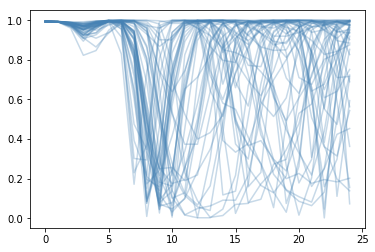

Accumulated costs: 0.908411:   0%|          | 2/1000 [00:00<01:28, 11.30it/s]

Policy search iteration 6


Accumulated costs: 0.820549: 100%|██████████| 1000/1000 [01:42<00:00,  9.75it/s]


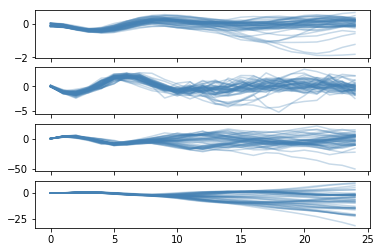

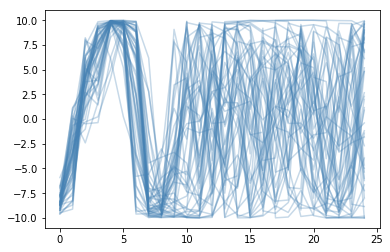

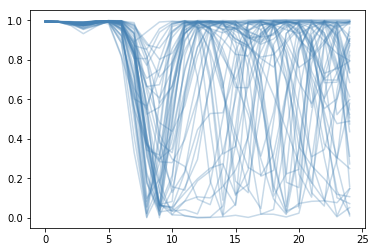

[2018-07-12 11:15:01.088086] apply_controller > Starting run
[2018-07-12 11:15:01.089919] apply_controller > Running for 2.500000 seconds
[2018-07-12 11:15:01.241717] apply_controller > Done. Stopping robot. Value of run [21.805918]
[2018-07-12 11:15:01.243331] Cartpole > Stopping robot


log-likelihood of data: 6.198291: 100%|█████████▉| 999/1000 [00:08<00:00, 116.93it/s]


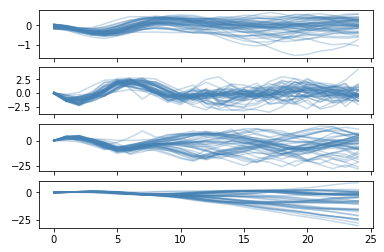

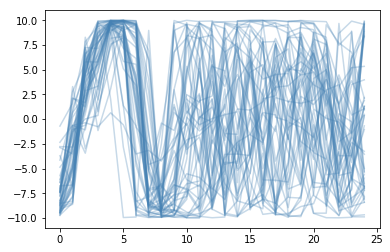

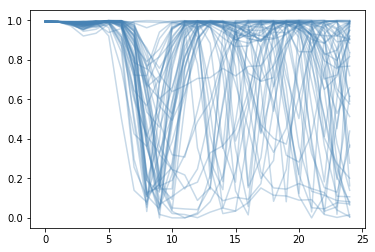

Accumulated costs: 0.860405:   0%|          | 2/1000 [00:00<01:28, 11.32it/s]

Policy search iteration 7


Accumulated costs: 0.834570: 100%|██████████| 1000/1000 [01:55<00:00,  8.63it/s]


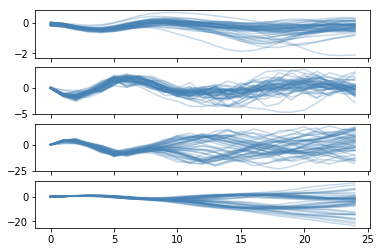

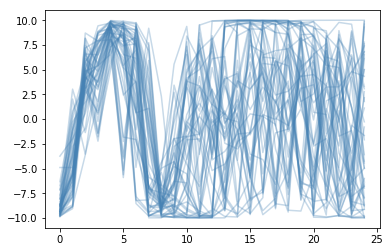

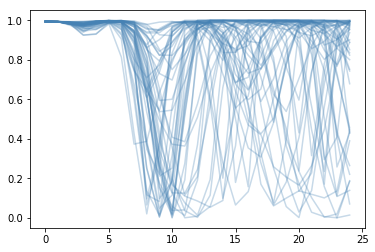

[2018-07-12 11:17:09.418153] apply_controller > Starting run
[2018-07-12 11:17:09.420467] apply_controller > Running for 2.500000 seconds
[2018-07-12 11:17:09.568579] apply_controller > Done. Stopping robot. Value of run [17.003822]
[2018-07-12 11:17:09.570017] Cartpole > Stopping robot


log-likelihood of data: 6.398090: 100%|██████████| 1000/1000 [00:09<00:00, 100.28it/s]


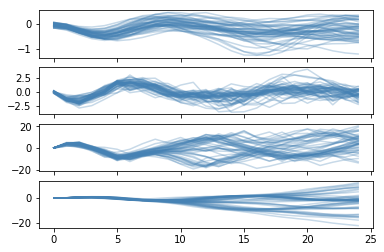

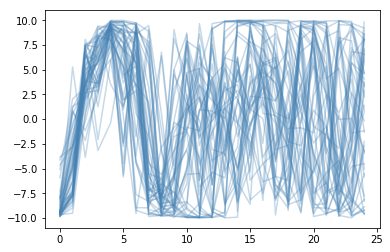

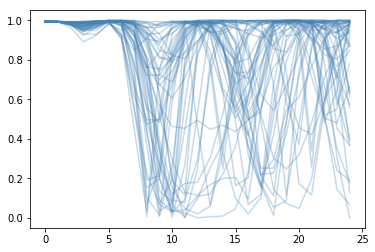

Accumulated costs: 0.855385:   0%|          | 1/1000 [00:00<02:38,  6.32it/s]

Policy search iteration 8


Accumulated costs: 0.754344: 100%|██████████| 1000/1000 [02:31<00:00,  6.60it/s]


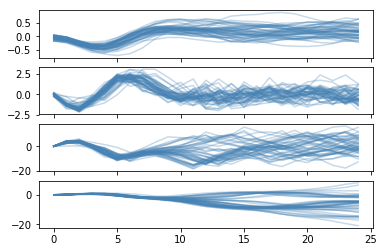

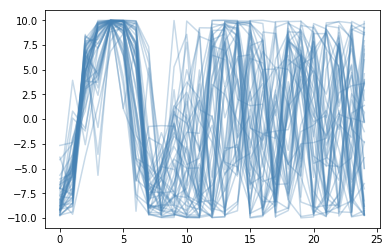

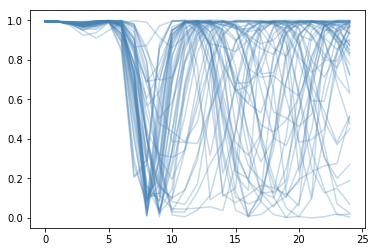

[2018-07-12 11:19:54.989414] apply_controller > Starting run
[2018-07-12 11:19:54.991744] apply_controller > Running for 2.500000 seconds
[2018-07-12 11:19:55.154256] apply_controller > Done. Stopping robot. Value of run [19.602629]
[2018-07-12 11:19:55.155578] Cartpole > Stopping robot


log-likelihood of data: 6.585238: 100%|██████████| 1000/1000 [00:11<00:00, 83.48it/s]


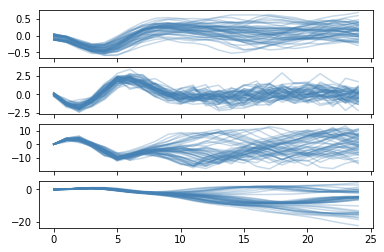

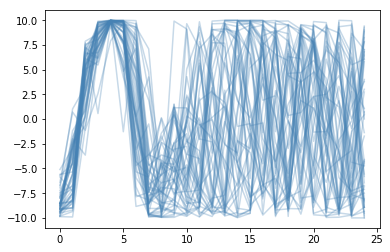

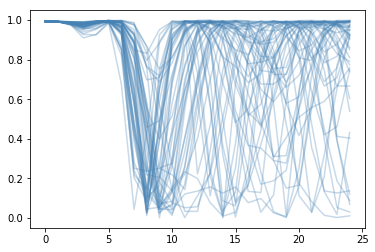

Accumulated costs: 0.781336:   0%|          | 1/1000 [00:00<02:23,  6.95it/s]

Policy search iteration 9


Accumulated costs: 0.679080: 100%|██████████| 1000/1000 [02:51<00:00,  5.82it/s]


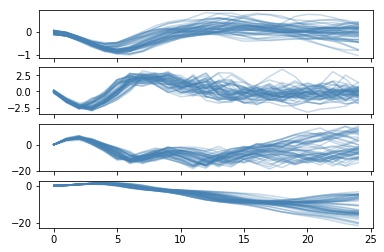

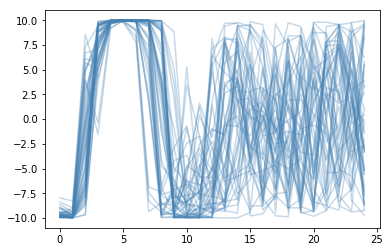

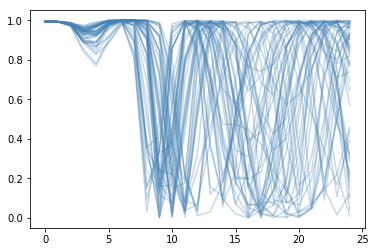

[2018-07-12 11:23:03.272762] apply_controller > Starting run
[2018-07-12 11:23:03.275293] apply_controller > Running for 2.500000 seconds
[2018-07-12 11:23:03.486607] apply_controller > Done. Stopping robot. Value of run [20.120646]
[2018-07-12 11:23:03.488103] Cartpole > Stopping robot


log-likelihood of data: 6.663527:  99%|█████████▉| 994/1000 [00:11<00:00, 84.02it/s]


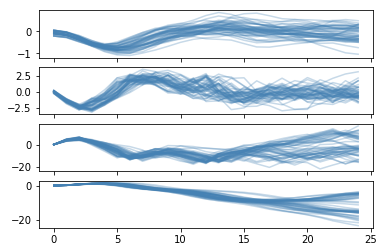

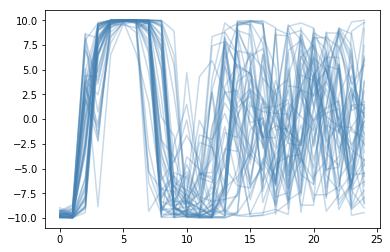

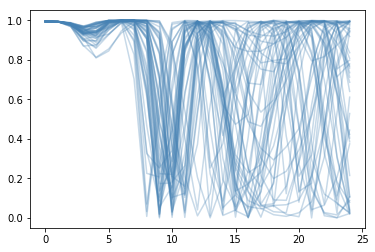

Accumulated costs: 0.866599:   0%|          | 1/1000 [00:00<02:23,  6.97it/s]

Policy search iteration 10


Accumulated costs: 0.804432: 100%|██████████| 1000/1000 [02:23<00:00,  6.96it/s]


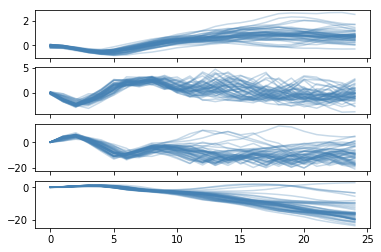

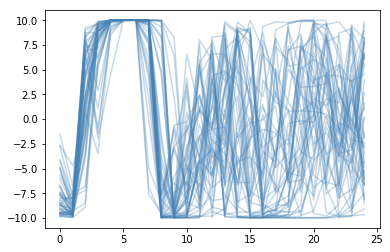

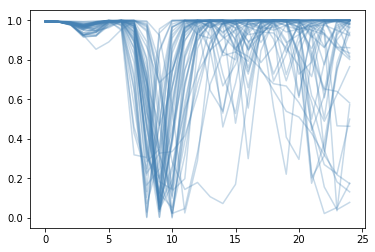

[2018-07-12 11:25:42.689401] apply_controller > Starting run
[2018-07-12 11:25:42.691973] apply_controller > Running for 2.500000 seconds
[2018-07-12 11:25:42.894116] apply_controller > Done. Stopping robot. Value of run [23.475803]
[2018-07-12 11:25:42.895356] Cartpole > Stopping robot


log-likelihood of data: 6.723536: 100%|█████████▉| 997/1000 [00:11<00:00, 87.55it/s]


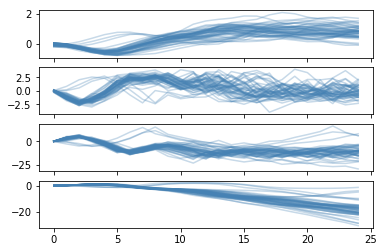

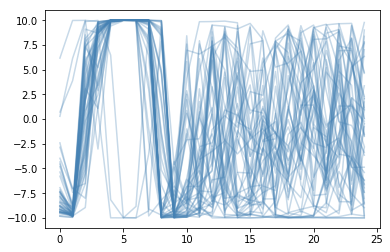

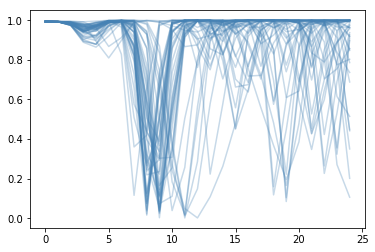

Accumulated costs: 0.904450:   0%|          | 1/1000 [00:00<02:20,  7.12it/s]

Policy search iteration 11


Accumulated costs: 0.741941: 100%|██████████| 1000/1000 [02:25<00:00,  6.85it/s]


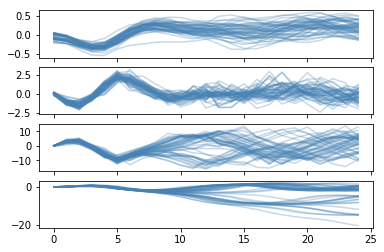

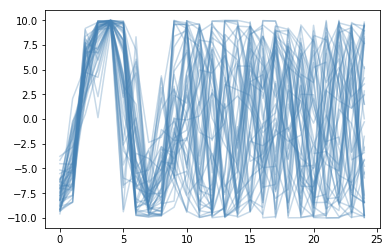

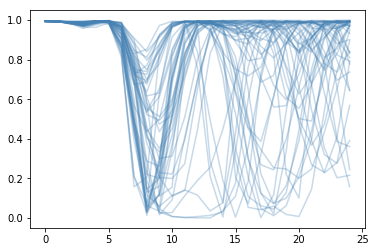

[2018-07-12 11:28:23.969652] apply_controller > Starting run
[2018-07-12 11:28:23.971311] apply_controller > Running for 2.500000 seconds
[2018-07-12 11:28:24.123979] apply_controller > Done. Stopping robot. Value of run [22.557949]
[2018-07-12 11:28:24.125244] Cartpole > Stopping robot


log-likelihood of data: 6.423938:  99%|█████████▉| 991/1000 [00:10<00:00, 93.97it/s]


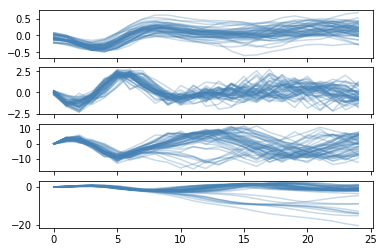

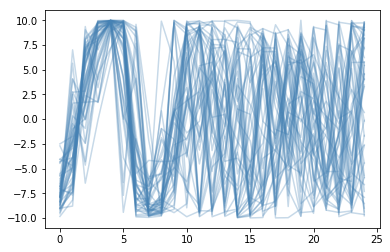

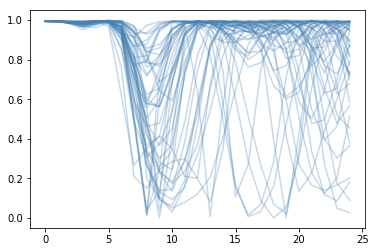

Accumulated costs: 0.786951:   0%|          | 1/1000 [00:00<02:16,  7.33it/s]

Policy search iteration 12


Accumulated costs: 0.765277: 100%|██████████| 1000/1000 [02:17<00:00,  7.30it/s]


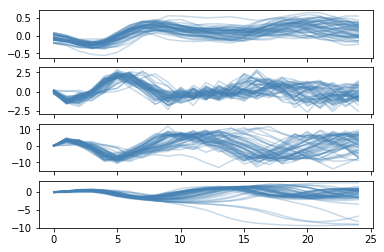

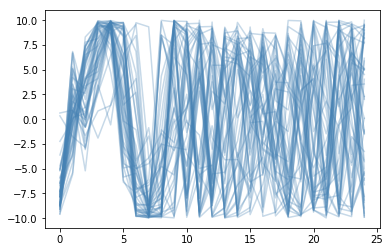

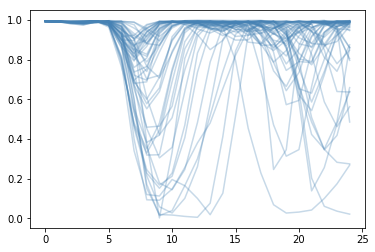

[2018-07-12 11:30:55.417116] apply_controller > Starting run
[2018-07-12 11:30:55.419568] apply_controller > Running for 2.500000 seconds
[2018-07-12 11:30:55.563212] apply_controller > Done. Stopping robot. Value of run [20.242908]
[2018-07-12 11:30:55.564496] Cartpole > Stopping robot


log-likelihood of data: 7.419102: 100%|█████████▉| 999/1000 [00:10<00:00, 91.42it/s]


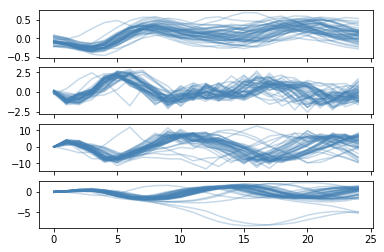

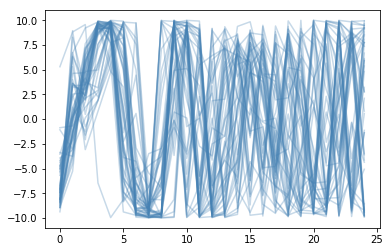

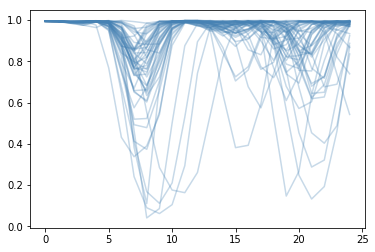

Accumulated costs: 0.889936:   0%|          | 1/1000 [00:00<02:20,  7.12it/s]

Policy search iteration 13


Accumulated costs: 0.789588: 100%|██████████| 1000/1000 [02:16<00:00,  7.32it/s]


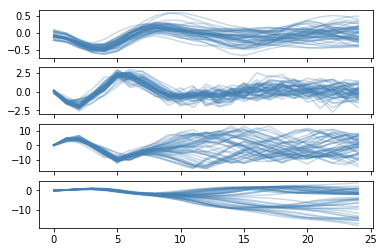

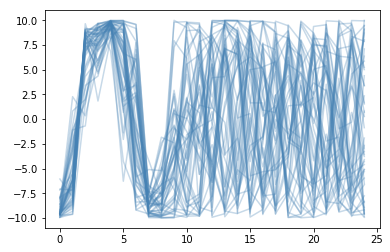

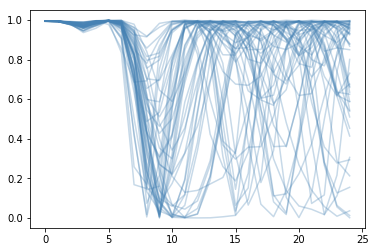

[2018-07-12 11:33:26.842036] apply_controller > Starting run
[2018-07-12 11:33:26.843724] apply_controller > Running for 2.500000 seconds
[2018-07-12 11:33:26.991420] apply_controller > Done. Stopping robot. Value of run [23.175884]
[2018-07-12 11:33:26.993048] Cartpole > Stopping robot


log-likelihood of data: 7.569945:  99%|█████████▉| 992/1000 [00:10<00:00, 94.37it/s]


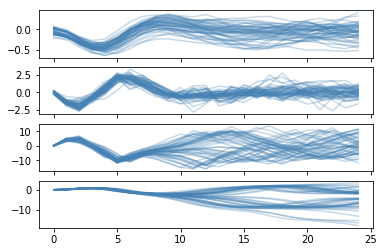

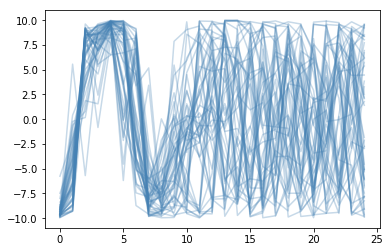

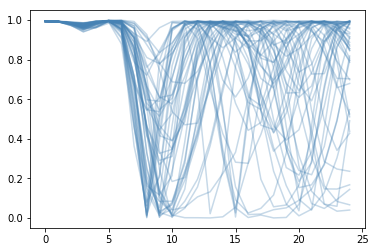

Accumulated costs: 0.852564:   0%|          | 1/1000 [00:00<02:10,  7.65it/s]

Policy search iteration 14


Accumulated costs: 0.814731:  96%|█████████▌| 958/1000 [02:09<00:05,  7.38it/s]

In [ ]:
# policy learning loop
for ps_it in range(100):
    # apply policy
    ret = apply_controller(
        env, pol, H,
        callback=None)
    exp.append_episode(*ret)

    # train dynamics
    X, Y = exp.get_dynmodel_dataset(deltas=True, return_costs=learn_reward)
    dyn.set_dataset(
        torch.tensor(X).to(dyn.X.device).float(),
        torch.tensor(Y).to(dyn.X.device).float())
    train_regressor(
        dyn, 1000, N_particles, True,
        log_likelihood=losses.gaussian_mixture_log_likelihood)

    # sample initial states for policy optimization
    x0 = torch.tensor(
        exp.sample_states(N_particles, timestep=0)).to(dyn.X.device).float()
    x0 += 1e-2*x0.std(0)*torch.randn_like(x0)
    utils.plot_rollout(x0, forward_fn, pol, H)

    # train policy
    print "Policy search iteration %d" % (ps_it+1)
    algorithms.mc_pilco(
        x0, forward_fn, dyn, pol, H, opt, exp=exp,
        maximize=False, pegasus=True, mm_states=True,
        mm_rewards=False, mpc=False, max_steps=25)
    utils.plot_rollout(x0, forward_fn, pol, H)
